# Báo cáo đồ án:
# Song song và tối ưu hóa một ứng dụng

Thực hiện:
- 21424080 - Đàm Văn Nhanh
- 21424079 - Nguyễn Duy Nam

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
cd /content/gdrive/MyDrive/SeamCarving-CUDA-C

/content/gdrive/MyDrive/SeamCarving-CUDA-C


In [4]:
from numba import cuda
major, minor = cuda.get_current_device().compute_capability
print(f'GPU compute capability: {major}.{minor}')

GPU compute capability: 7.5


In [5]:
from PIL import Image
import numpy as np
def show_pnm(file_name):
    with open(file_name, 'r') as f:
        vals = f.read().split()
    w = int(vals[1])
    h = int(vals[2])
    if vals[0] == 'P2': # Grayscale
        pixels = np.array(vals[4:], dtype=np.uint8).reshape((h, w))
    elif vals[0] == 'P3': # RGB
        pixels = np.array(vals[4:], dtype=np.uint8).reshape((h, w, 3))
    else:
        return None
    return Image.fromarray(pixels)
    
def convertImgtoPnm(fileName:str,outName:str):
  img =np.array( Image.open(fileName))
  h,w,_=img.shape
  with open(outName, 'w') as f:
      f.write("P3\n")
      f.write("{} {}\n".format(img.shape[1],img.shape[0]))
      f.write("255\n")
      for i in range(h):
        for j in range(w):
          f.write("{} {} {} ".format(img[i,j][0],img[i,j][1],img[i,j][2]))

#I. Mô tả

Mục tiêu: Thay đổi kích thước ảnh bằng phương pháp "**Seam Carving**", đánh giá và tìm ra phương pháp triển khai tối ưu.
- Input: Một tấm ảnh RGB có matrix with * height
- Output: Tấm ảnh có kích thước (newWidth x height) mà không làm biến dạng các đối tượng quan trọng của input
- Phương pháp triển khai:
  + Tuần tự
  + Song song
- Ứng dụng thực tế: hỗ trợ hiển thị ảnh trên nhiều thiết bi khác nhau, optimize memory khi lưu trữ.

#II. Cài đặt tuần tự

## 1. Thiết kế

### a) Ý tưởng:
- Tìm những pixel quan trọng (energy) bằng cách loại bỏ các pixel không quan trọng.
- Sau đó tìm một seam có tổng các energy của mỗi pixel trong nó là nhỏ nhất và tiến hành loại bỏ seam đó.




### b) Thuật toán:

  - Bước 1: Đọc 1 bức ảnh đầu vào

  - Bước 2: Chuyển ảnh RGB sang ảnh xám

  - Bước 3: Tìm độ quan trọng (energy) của mỗi pixel bằng phương pháp Edge Detection

  - Bước 4: Sử dụng Dynamic Programming để xây dựng Energy Map dựa trên Energy

  - Bước 5: Tìm đường seam có giá trị nhỏ nhất dựa trên Energy Map

  - Bước 6: Xóa seam vừa tìm được ứng với ảnh đầu vào

  - Bước 7: Lặp lại bước 2 cho đến khi ảnh đạt được kích thước đầu ra



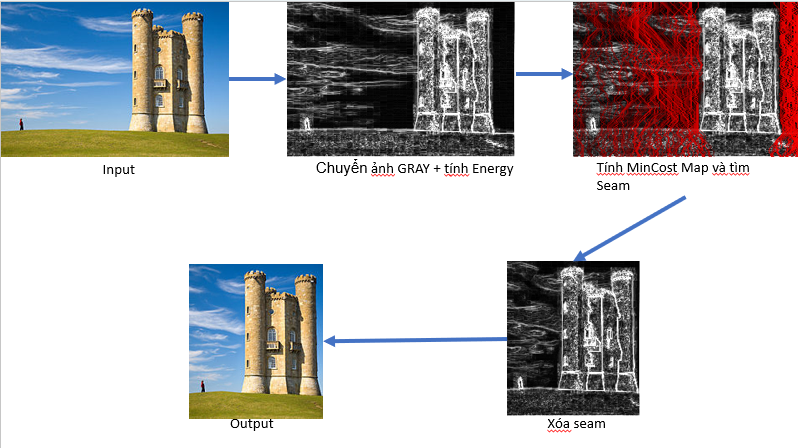

#### Chuyển ảnh RGB sang ảnh xám
Mỗi pixel trong ảnh RGB có ba giá trị tương ứng với ba kênh màu red, green, blue. Trong khi ảnh xám lại chỉ có một giá trị. Quá trình chuyển đổi sẽ tính lần lượt các pixel trong ảnh xám theo công thức:

>$gray = 0.299 * red + 0.587 * green + 0.114 * blue$

#### Tìm độ quan trọng của mỗi pixel (edge detection)
Sử dụng hai lớp convolution (tính toán năng lượng của mỗi pixel).
- Bộ lọc x-Sobel (chiều ngang) (1)
- Bộ lọc y-Sobel (chiều dọc) (2)
- Độ quan trọng = |kết quả của (1)| + |kết quả của (2)|

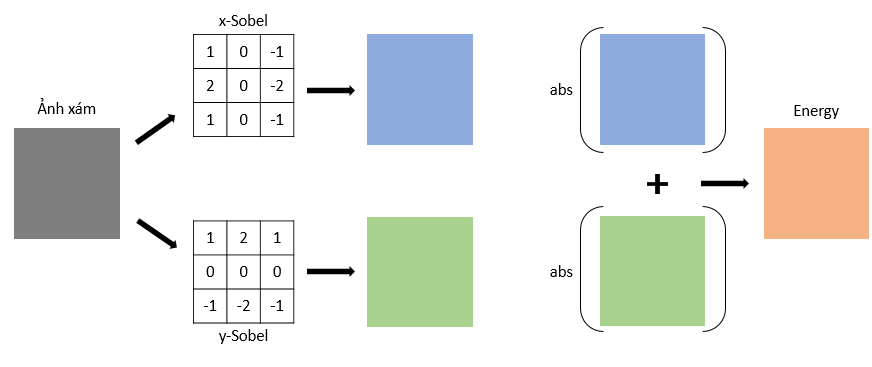

#### Xây dựng Energy Map (dynamic programming)

Khi đã có độ quan trọng của từng pixel trong ảnh, việc tiếp theo cần làm là tìm seam có độ quan trọng thấp nhất để loại bỏ. Sử dụng Dynamic Programming (quy hoạch động). Dynamic Programming sẽ tính lần lượt các dòng từ dưới lên trên, mỗi lần sẽ tính độ quan trọng ít nhất, tính tới dưới cùng của từng pixel. Sau khi có được Energy Map, để thuận tiện hơn cho tìm seam. Quá trình này sẽ được thực hiện song song cùng với xây dựng Energy Map.

- Dòng dưới cùng của Energy Map cũng chính là độ quan trọng của các pixel ở dòng này. Dòng dưới cùng của Directions (bảng truy vết) có giá trị là 0.

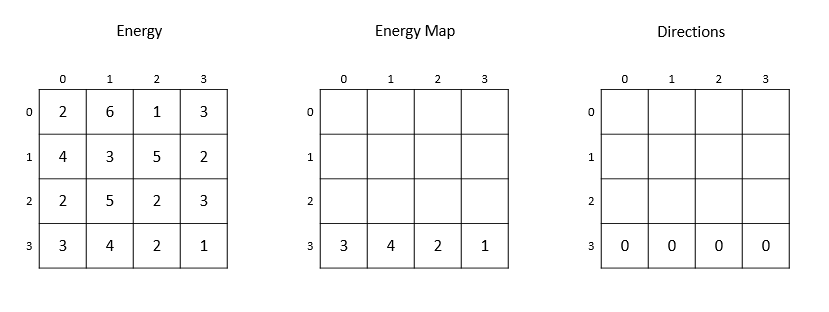

- Đối với Energy Map, tại dòng 2, giá trị của mỗi pixel bằng độ quan trọng của chính nó cộng với giá trị nhỏ nhất của 3 pixel phía dưới. Directions sẽ lưu lại vị trí (chỉ số cột) của pixel chứa giá trị nhỏ nhất này.

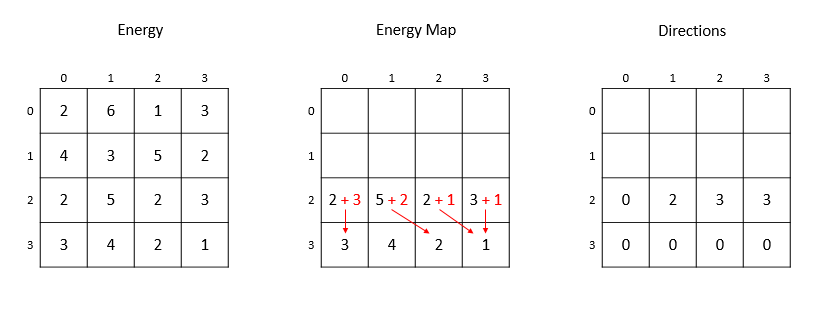

- Tiếp tục như vậy cho đến hết, ta sẽ được Energy Map và bảng truy vết của nó.

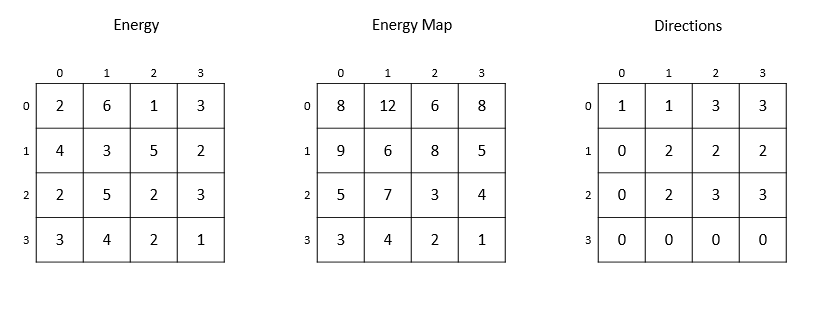

#### Tìm seam có độ quan trọng nhỏ nhất

Từ Energy Map thu được ở trên, ta dễ dàng tìm được seam có tổng độ quan trọng của các pixel là nhỏ nhất dựa trên dòng trên cùng của bảng. Seam cần tìm sẽ bắt đầu từ pixel có giá trị nhỏ nhất ở dòng đầu tiên của Energy Map. Từ đó, quay lui trên Directions ta sẽ xác định được seam.

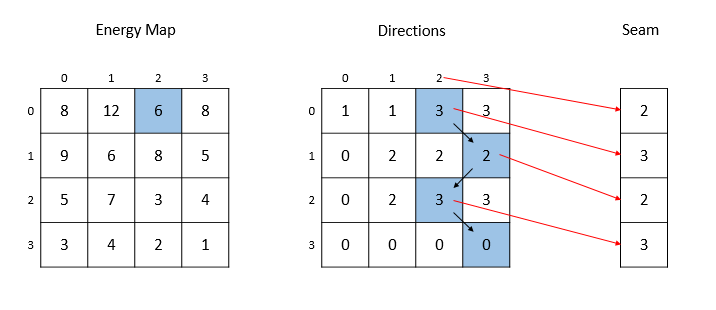

#### Xóa seam

Thao tác xóa seam sẽ được thực hiện bằng cách copy các pixel trên từng dòng (trừ pixel nằm trên seam).

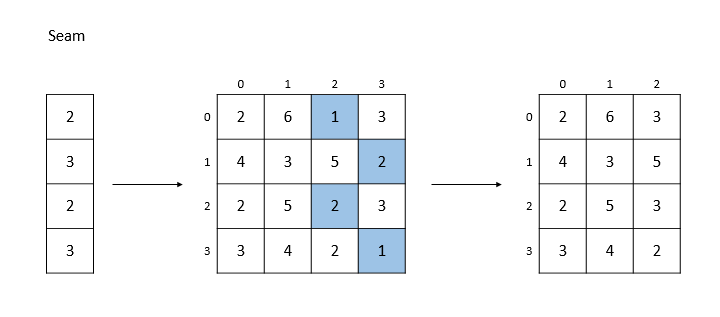

##2.  Đánh giá

**Tiến** hành chạy chương trình SeamCarving tuần tự trên:
- Một ảnh 411x279 tạo ra ba ảnh có chiều rộng lần lượt là 400, 300, 200
- Một ảnh 1428x986 tạo ra ba ảnh có chiều rộng lần lượt là 1300, 1200, 1100

Kết quả thu được sẽ bao gồm thời gian thực thi của mỗi lần chạy chương trình.

In [6]:
ls

12345.pnm         out_device.pnm       SeamCarvingByDevice
1234.pnm          out_host1.pnm        SeamCarvingByDevice11
host.pnm          out_host2.pnm        SeamCarvingByDevice12
img/              out_host3.pnm        SeamCarvingByDevice13
out_device11.pnm  out_large_host1.pnm  SeamCarvingByDevice2
out_device12.pnm  out_large_host2.pnm  SeamCarvingByHost
out_device13.pnm  out_large_host3.pnm  Seam_Carving.ipynb
out_device2.pnm   readme.md            Source/


In [7]:
!nvcc -arch=sm_{major}{minor} Source/SeamCarvingByHost.cu -o SeamCarvingByHost

In [8]:
!./SeamCarvingByHost Source/in.pnm out.pnm 400 300 200


Image size (width x height): 411 x 279

Seam carving by host
New image size (width x height): 400 x 279
Time: 371.431 ms

Seam carving by host
New image size (width x height): 300 x 279
Time: 2170.996 ms

Seam carving by host
New image size (width x height): 200 x 279
Time: 4028.869 ms


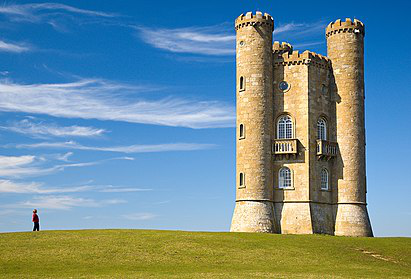

In [9]:
show_pnm("Source/in.pnm")

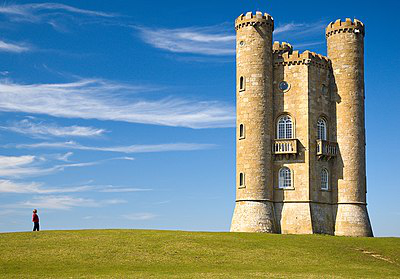

In [10]:
show_pnm("out_host1.pnm")

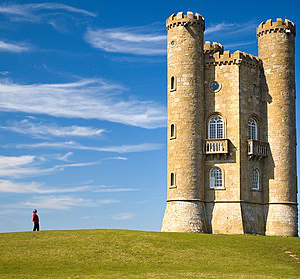

In [11]:
show_pnm("out_host2.pnm")

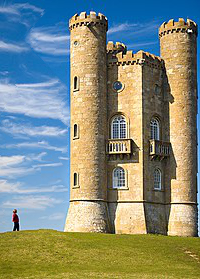

In [12]:
show_pnm("out_host3.pnm")

In [13]:
!./SeamCarvingByHost Source/in_large.pnm out_large.pnm 1300 1200 1100


Image size (width x height): 1428 x 968

Seam carving by host
New image size (width x height): 1300 x 968
Time: 38450.066 ms

Seam carving by host
New image size (width x height): 1200 x 968
Time: 65737.352 ms

Seam carving by host
New image size (width x height): 1100 x 968
Time: 89853.797 ms


#### Nhận xét:
- Ảnh sau khi thu hẹp vẫn giữ nguyên các chủ thể chính, cấu trúc ảnh không bị vỡ, không gian khoảng trống được thu hẹp, đạt được yêu cầu đầu ra.
- Khi chạy với ảnh lớn hơn thì chương trình mất rất nhiều thời gian. Do đó, việc song song hóa chương trình là điều cần thiết.

#III. Cài đặt song song

## 1. Phân tích

- Nhóm sẽ tiến hành song song hóa phiên bản tuần tự những phần sau:
  1. Chuyển ảnh RGB sang ảnh GrayScale
  2. Tính Energy cho từng pixel trên ảnh GrayScale
  3. Xây dựng Energy Map từ Energy
  4. Tìm giá trị nhỏ nhất (tìm seam có energy nhỏ nhất)
  5. Xóa seam trên ảnh RGB
- Lý do nhóm chọn những phần trên là vì nhận thấy rằng: Những bước trên ảnh hưởng đến tốc độ thực thi của chương trình, cần song song hóa để tối ưu thời gian chạy và có thể dễ dàng song song được.   


## 2. Thiết kế

#### Chuyển ảnh RGB sang GrayScale
Ta sẽ sử dụng grid và block 2 chiều sao cho mỗi thread sẽ xử lý tính grayScale cho 1 pixel trên ảnh RGB.

#### Tính Energy cho từng pixel trên ảnh GrayScale
Việc tính Energy về bản chất là các lớp convolution, ta cũng sử dụng grid và block 2 chiều, và mỗi thread sẽ làm nhiệm vụ tính toán energy cho một pixel trên GrayScale và ghi vào mảng Energy.

#### Xây dựng Energy Map từ Energy
Ở thuật toán tuần tự, ta sử dụng kỹ thuật quy hoạch động cho nên việc tính toán mincost trên dòng `r` phải có kết quả  dòng `r + 1` mới tính được. Vậy nên ta không thể viết hàm song song để tính Energy Map trong 1 lần duy nhất mà cần song song việc tính Energy Map trên 1 dòng và lặp lại trên từng dòng. Ta sẽ sử dụng grid và block 1 chiều, và mỗi thread sẽ làm nhiệm vụ tính giá trị của 1 pixel.

#### Tìm giá trị nhỏ nhất (tìm seam có energy nhỏ nhất)
Việc tìm min trên 1 dòng của bảng Energy Map có thể không mất quá nhiều thời gian khi thực hiện tìm tuần tự, nhưng có thể song song để tối ưu hóa thời gian. Ý tưởng cho việc tìm min và index min song song đó là sử dụng phương pháp reduce để tìm min và index trên 1 block, cuối cùng làm tìm Min tuần tự trên toàn bộ block.

#### Xóa seam trên ảnh RGB
Ý tưởng của việc xóa seam đó là gán lại kết quả từ ảnh Input vào ảnh Output nhưng không gán những đường seam vì vậy có thể chia một pixel cho từng thread để gán.

## 3. Đánh giá

*Kết* quả của phiên bản tuần tự sẽ được lấy làm chuẩn để so sánh với kết quả của các phiên bản song song hóa. Hàm tính độ lỗi sẽ lấy trung bình của các chênh lệch trên từng pixel.

In [14]:
!nvcc -arch=sm_{major}{minor} Source/SeamCarvingByDevice.cu -o SeamCarvingByDevice

In [ ]:
!./SeamCarvingByDevice Source/in.pnm out_device.pnm 200

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15835398144 byte
SMEM per SM: 65536 byte
SMEM per block: 49152 byte
****************************

Image size (width x height): 411 x 279

Seam carving by host
Time: 3925.463 ms

Seam carving by device
Time: 675.615 ms
Error: 0.000000


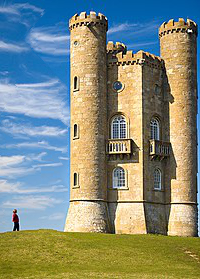

In [ ]:
show_pnm("out_device.pnm")

#### Nhận xét:
- Ảnh đầu ra của phiên bản song song hoàn toàn trùng khớp với ảnh được tạo ra từ phiên bản tuần tự.
- Thời gian thực thi nhanh hơn gấp 5 lần.

#IV. Cài đặt song song - version 1

## Phiên bản 1.1: Tối ưu Kernel `findEnergy` -> `findEnergy_v1`

**Phân tích**: Do mỗi thread sẽ thực hiện convolution 9 lần ứng với kích thước Sobel Filter, nên sẽ có 9 lần đọc input từ Global Memory<br>
=> *Giải pháp*: Ta sẽ sử dụng Shared Memory để giảm thời gian thread phải truy cập xuống Global Memory

**Thiết kế**: Shared Memory ở mỗi Block sẽ có kích thước là: `Kích thước Block` + `Kích thước filter - 1`. Do kích thước Shared Memory lớn hơn kích thước Block nên sẽ có các Thread thực thi nhiều hơn 1 lần

**Đánh giá**: Rất tiếc vì code đã không nhanh hơn<br>
*Nguyên nhân*: Có thể do phần đọc dữ liệu từ Global Memory và ghi vào Shared Memory không hiệu quả.


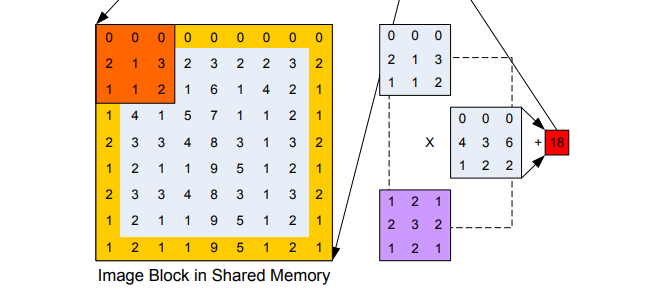

In [ ]:
!nvcc -arch=sm_{major}{minor} Source/SeamCarvingByDevice11.cu -o SeamCarvingByDevice11

In [ ]:
!./SeamCarvingByDevice11 Source/in.pnm out_device11.pnm 200

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15835398144 byte
SMEM per SM: 65536 byte
SMEM per block: 49152 byte
****************************

Image size (width x height): 411 x 279

Seam carving by host
Time: 3190.278 ms

Seam carving by device
Time: 776.030 ms
Error: 0.000000


## Phiên bản 1.2: Tối ưu Kernel `findEnergy` -> `findEnergy_v2`

**Phân tích**: Sử dụng Constant Memory cho Filter sẽ giảm thời gian so với việc phải truy cập xuống Global Memory

**Thiết kế**: Làm tương tự như `findEnergy`, nhưng sử dụng Filter đã được lưu ở Constant Memory

**Đánh giá**: Giảm được một chút thời gian so với ban đầu. Tuy nhiên do kích thước Filter khá nhỏ nên cải thiện chênh lệch không đáng kể

In [8]:
!nvcc -arch=sm_{major}{minor} Source/SeamCarvingByDevice12.cu -o SeamCarvingByDevice12

In [9]:
!./SeamCarvingByDevice12 Source/in.pnm out_device12.pnm 200

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15835398144 byte
SMEM per SM: 65536 byte
SMEM per block: 49152 byte
****************************

Image size (width x height): 411 x 279

Seam carving by host
Time: 3295.213 ms

Seam carving by device
Time: 683.329 ms
Error: 0.000000


## Phiên bản 1.3: Tối ưu Kernel `findEnergy` -> Sử dụng Separable Convolution

**Phân tích**: <br>
*Ưu điểm*: 
- Sử dụng *Separable Convolution* cho Sobel Filter sẽ giúp giảm số lần tính toán ở mỗi pixel từ (W * H) -> (W + H). 
- Với Row Convolution: Chúng ta sẽ không cần padding ở phía trên và phía dưới
- Với Column Convolution: Chúng ta sẽ không cần padding ở bên trái và bên phải
=> Giúp ta có thể tăng số lượng thread để xử lí

*Nhược điểm*: 
- Phải thực hiện ghi kết quả Output xuống Global Memmory giữa Row Convolution và Column Convolution. Ngoài ra còn phải ghi đến 2 lần xuống Output trung gian do có 2 Filter.

**Thiết kế**: Dùng 2 kernel: 1 kernel cho *Row Filter* và lấy kết quả dùng cho *Column Filter*

**Đánh giá**: Hàm có cải thiện khi tăng kích thước Filter, tuy nhiên do Filter khá nhỏ (9) nên cách tiếp cận này không phát huy trong trường hợp này.

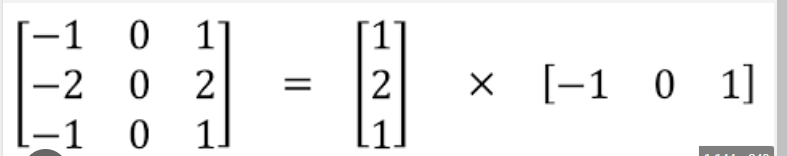

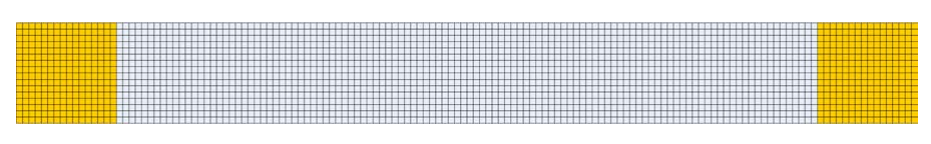

In [ ]:
!nvcc -arch=sm_{major}{minor} Source/SeamCarvingByDevice13.cu -o SeamCarvingByDevice13

In [ ]:
!./SeamCarvingByDevice13 Source/in.pnm out_device13.pnm 200

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15835398144 byte
SMEM per SM: 65536 byte
SMEM per block: 49152 byte
****************************

Image size (width x height): 411 x 279

Seam carving by host
Time: 2588.939 ms

Seam carving by device
Time: 781.782 ms
Error: 0.000000


## Kết luận
Do phiên bản 1.2 cho ra kết quả tốt nhất nên nhóm sẽ chọn phiên bản này 

# V. Cài đặt song song - version 2

## Phiên bản 2: Tối ưu Kernel `findEnergyMapAndDirections`

Phân tích: Do việc truy xuất xuống Global Memory cũng phải thực hiện nhiều lần nên nhóm sẽ thử nghiệm sử dụng Shared Memory 

Đánh giá: Thời gian thực thi cũng không được cải thiện đáng kể. Rất có thể cũng do phần copy dữ liệu từ Global Memory sang Shared Memory chưa được code hiệu quả.

In [6]:
!nvcc -arch=sm_{major}{minor} Source/SeamCarvingByDevice2.cu -o SeamCarvingByDevice2

In [7]:
!./SeamCarvingByDevice2 Source/in.pnm out_device2.pnm 200

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15835398144 byte
SMEM per SM: 65536 byte
SMEM per block: 49152 byte
****************************

Image size (width x height): 411 x 279

Seam carving by host
Time: 4983.769 ms

Seam carving by device
Time: 692.900 ms
Error: 0.000000


## Kết luận
Do phiên bản 2.1 không cải thiện nhiều nên nhóm sẽ không chọn phiên bản này :(

## Nhận xét: 
Cả 2 hàm cải tiến có dùng Shared Memory ở trên đều không gặp phải hiện tượng Bank Conflict, nhóm đã kiểm tra bằng cách dùng Nsight Compute

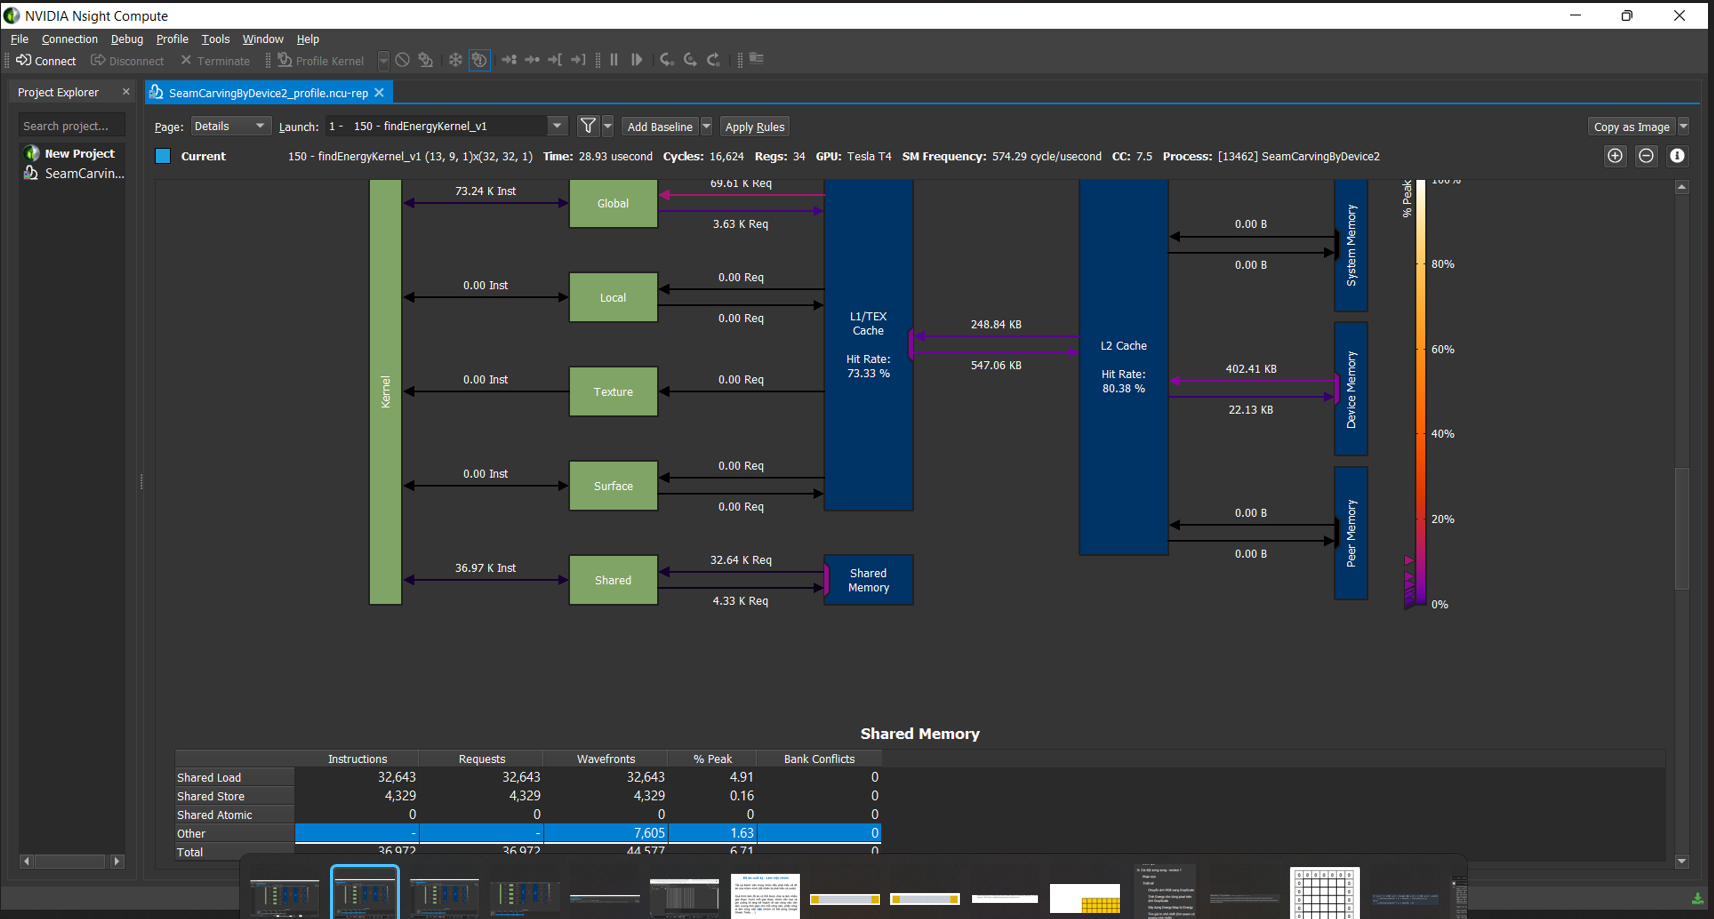

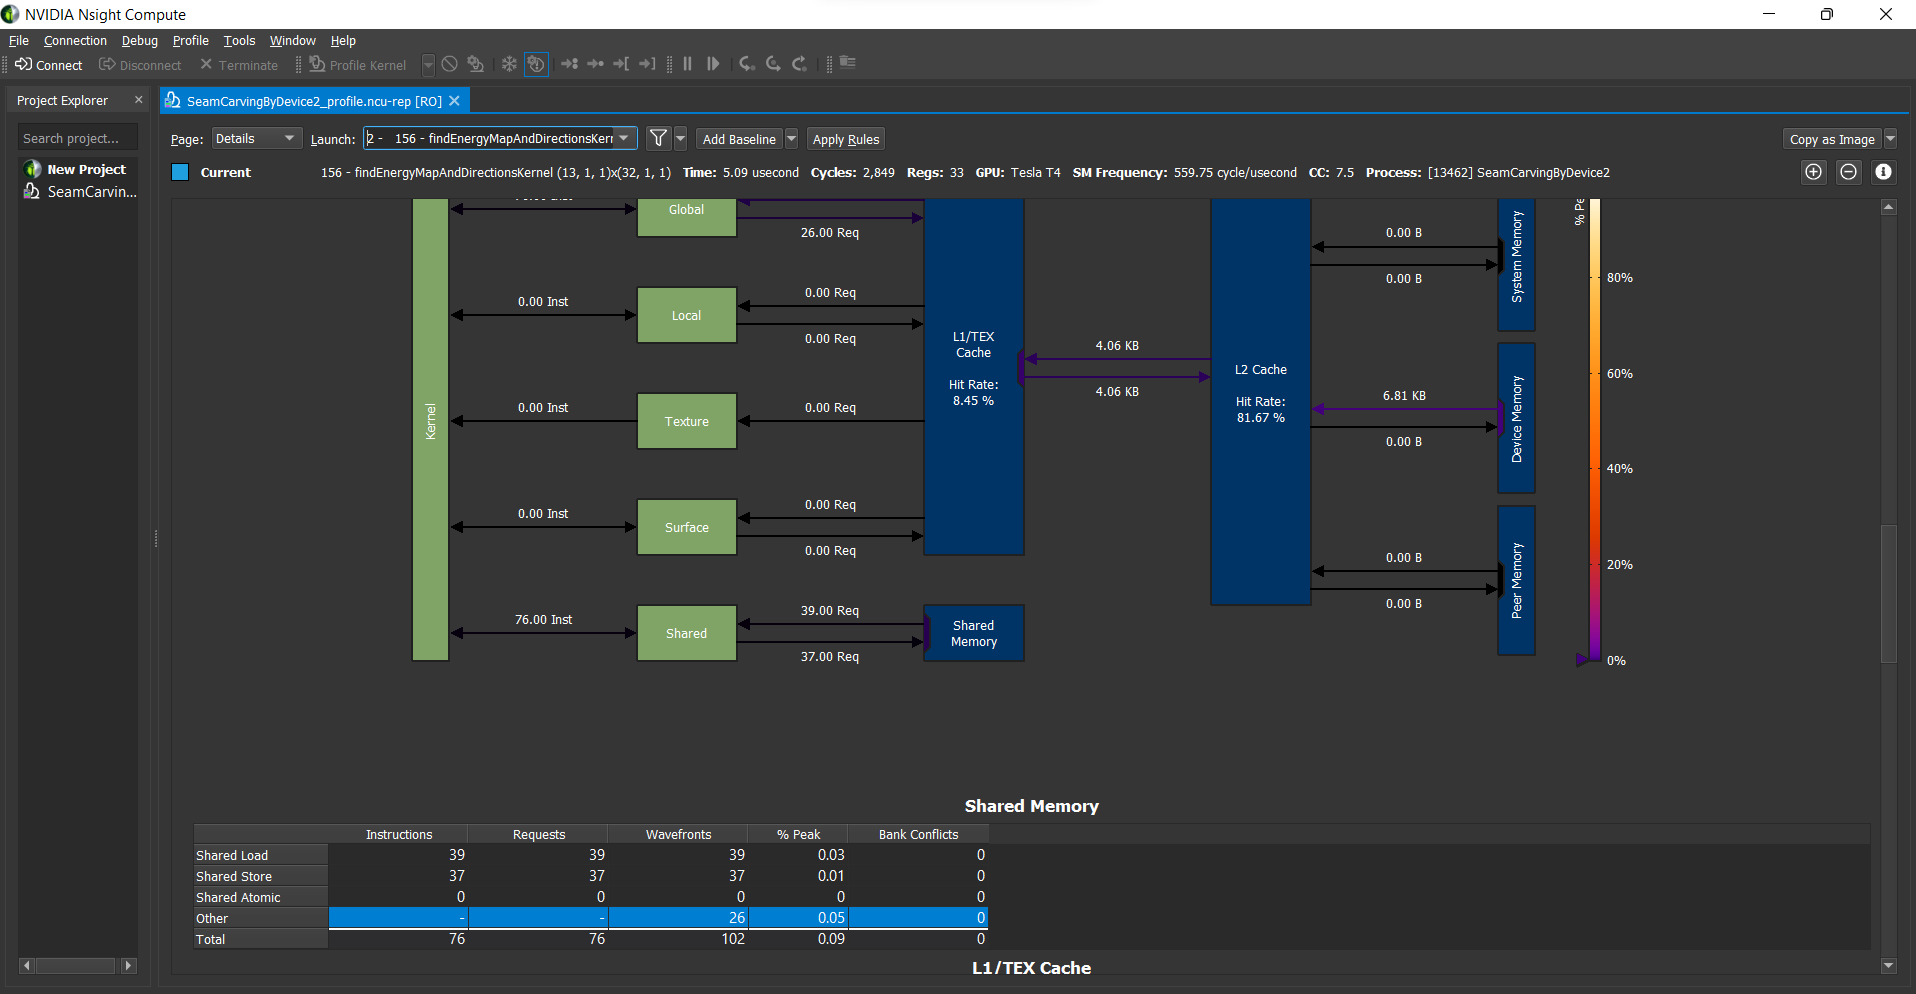

# VI. Nhìn lại quá trình làm đồ án

* Những khó khăn mà nhóm đã gặp phải:

  - Việc phân tích và tối ưu phần song song còn nhiều khó khăn dẫn đến tiến độ làm việc chậm.
  - Các bước cài đặt tuần tự -> song song -> tối ưu cần làm tuần tự nên khó khăn cho việc phân công công việc
  - Do kĩ năng code và phân tích code chưa quá tốt nên còn gặp một số khó khăn khi đưa ý tưởng vào code

* Những hữu ích học được.
 - Cải thiện khả năng làm việc nhóm
 - Biết cách phân tích, cài đặt, song song hóa và tìm cách tối ưu một thuật toán
 - Giúp phát triển, cải thiện tư duy làm việc song song một cách hiệu quả 
* Phát triển thêm trong tương lai:
 - Tìm cách tối ưu thuật toán bằng cách sử dụng stream
 - Cải thiện tốc độ thực thi của các bản song song
 - Báo cáo cài đặt nội dung chi tiết hơn
 - Ở bản cải tiến dùng Shared Memory: Tinh chỉnh việc ghi dữ liệu ở Shared Memory tốt hơn, quản lí Register Memory cho các Thread tốt hơn

#VII. Tài liệu tham khảo

- https://www.youtube.com/watch?v=rpB6zQNsbQU
- https://www.youtube.com/watch?v=ALcohd1q3dk
- https://en.wikipedia.org/wiki/Seam_carving
- [Shared Memory Document - NVIDA](https://developer.nvidia.com/blog/using-shared-memory-cuda-cc/)<br>
-[Smem nhưng không hiệu quả - Stackoverflow](https://stackoverflow.com/questions/26950664/pointless-use-of-cuda-shared-memory)<br>
-[Smem nhưng không hiệu quả - NVIDIA Forum](https://forums.developer.nvidia.com/t/convolution-using-shared-memory-slowdown-instead-of-speedup/15436)<br>
-[Tài liệu NVIDIA về Separable Convolution (published 200x)](http://www.songho.ca/dsp/convolution/convolution2d_separable.html)<br>
-[Chứng minh dễ hiểu về Separable Convolution](https://developer.download.nvidia.com/compute/cuda/1.1-Beta/x86_64_website/projects/convolutionSeparable/doc/convolutionSeparable.pdf)<br>
-[Nsight Compute Document](https://developer.nvidia.com/nsight-compute)<br>
-[Speed of Light in Nsight Compute](https://forums.developer.nvidia.com/t/what-is-sol-speed-of-light/191348)
